In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from tqdm import tqdm

import pandas as pd
import os

In [55]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cpu'

In [ ]:
df = pd.read_csv("../data/train_labels.csv", names=['img_name', 'label'], header=1)

df = df.append([df[df["label"] == 20]] * 15, ignore_index = True)
df = df.sample(frac=1, random_state = 42).reset_index(drop=True)

df.shape

In [56]:
class food_set(Dataset):

    def __init__(self, df, labels_file, img_dir, extractor, transform = None, settype = "train"):
        self.df = df
        if settype == "train":
            self.img_labels = df[:30000]
        elif settype == "val":
            self.img_labels = df[30000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image)["pixel_values"][0]      
        
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [58]:
class food_test(Dataset):

    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = read_image(img_path)
       
        if self.transform:
            image = self.transform(image)
        
        return file_name, image

In [104]:
import torch.utils.data as data_utils

img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

transform = transforms.Compose(
                    [transforms.Resize((256,256)),
                     transforms.ConvertImageDtype(torch.float),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])])

trainset = food_set(df, labels, img_dir, feature_extractor, transform = transfors, settype = "train")
valset = food_set(df, labels, img_dir, feature_extractor, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=0)

len(trainset), len(valset)

(2500, 562)

In [60]:
test_set = food_test("../data/test_set/test_set", transform = transform)
testloader = DataLoader(test_set, batch_size = 32, shuffle=True, num_workers=0)

len(test_set)

7654

In [ ]:
torch.cuda.get_device_name(0)

In [63]:
resnet = models.resnet18(pretrained=True)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [79]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

criterion = nn.CrossEntropyLoss()
search_space = {
    "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9)
}

In [80]:
def train_loop(config):
    
    dataloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
    criterion = nn.CrossEntropyLoss()
    size = len(dataloader.dataset)
    resnet.train()
    optimizer = optim.SGD(resnet.parameters(), lr=config["lr"], momentum=config["momentum"])
    
    for epoch in range(15):
        for batch, (image, label) in enumerate(dataloader):
            # Compute prediction and loss
            image, label = image.to(device), label.to(device)
            pred = resnet(image)
            loss = criterion(pred, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 200 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch}")
                
        print(f"Epoch: {epoch}")
        test_loop(valloader, resnet)


def test_loop(dataloader, model):
    
    criterion = nn.CrossEntropyLoss()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    tune.report(mean_accuracy=correct)
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [89]:
from ray.tune import JupyterNotebookReporter
reporter = JupyterNotebookReporter(overwrite=True, max_report_frequency = 60)

In [90]:
#train_loop(trainloader, resnet, criterion, optimizer)
analysis = tune.run(
    train_loop,
    num_samples=10,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space,
    progress_reporter=reporter)

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_loop_33bf8_00000,RUNNING,127.0.0.1:77232,1.01845e-09,0.291646,0.256228,2,2149.4
train_loop_33bf8_00001,TERMINATED,127.0.0.1:77231,1.2407e-05,0.853832,0.252669,1,1306.31
train_loop_33bf8_00002,TERMINATED,127.0.0.1:77135,0.000517434,0.713206,0.263345,1,1308.25


(ImplicitFunc pid=77232) 2021-12-10 14:37:15,073	ERROR worker.py:431 -- SystemExit was raised from the worker
(ImplicitFunc pid=77232) Traceback (most recent call last):
(ImplicitFunc pid=77232)   File "python/ray/_raylet.pyx", line 759, in ray._raylet.task_execution_handler
(ImplicitFunc pid=77232)   File "python/ray/_raylet.pyx", line 580, in ray._raylet.execute_task
(ImplicitFunc pid=77232)   File "python/ray/_raylet.pyx", line 618, in ray._raylet.execute_task
(ImplicitFunc pid=77232)   File "python/ray/_raylet.pyx", line 625, in ray._raylet.execute_task
(ImplicitFunc pid=77232)   File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
(ImplicitFunc pid=77232)   File "python/ray/_raylet.pyx", line 578, in ray._raylet.execute_task.function_executor
(ImplicitFunc pid=77232)   File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ray/_private/function_manager.py", line 609, in actor_method_executor
(ImplicitFunc pid=77232)     return method(__

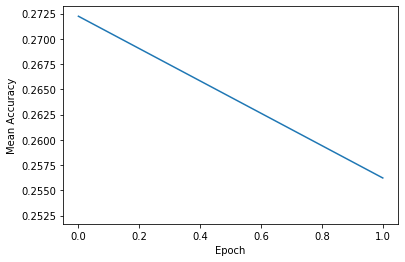

In [103]:
dfs = analysis.trial_dataframes
ax = None  # This plots everything on the same plot
for dataframe in dfs.values():
    ax = dataframe.mean_accuracy.plot(ax=ax, legend=False)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Mean Accuracy');
plt.show()

In [69]:
PATH = './transfered_resnet.pth'
torch.save(resnet.state_dict(), PATH)

In [71]:
resnet2 = models.resnet18()
resnet2.load_state_dict(torch.load("../transfered_resnet.pth"))
resnet2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = resnet2(X).argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

In [26]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_6060.jpg,21
1,test_3540.jpg,6
2,test_4430.jpg,72
3,test_695.jpg,10
4,test_4999.jpg,37


In [27]:
test_df.to_csv("submission.csv", index=False)